In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

import fiona
from shapely.geometry import shape

import numpy as np
import os
from collections import defaultdict, OrderedDict 

## Fiona, ogr2ogr, pyplot demo
##  Live 8.5  *  darkblue-b
##

`Demo Area Analysis in IPython Notebook`

  * Use North Carolina sample data supplied on the OSGeo Live 
  * Extract an area of interest
  * Extract a subset of a state soils record based on a bounding box (BBOX)
  * Plot geometry graphically
  * Buffer the geometry by a fixed amount; calculate the areas of intersection for soil types
  * Produce a chart of the totals with pyplot

In [2]:
infile = '/usr/local/share/data/north_carolina/shape/urbanarea.shp'
infile_soils = '/usr/local/share/data/north_carolina/shape/soils_general.shp'

out_farmville = '/tmp/farmville_shp'
out_farmville_soils = '/tmp/farmville_soil_shp'

In [3]:
## -- Call the gdal/ogr tool suite to extract and subset the original statewide dataset
##     use a feature of IPython Notebook to pass python variables to a command line

!rm -rf $out_farmville
!ogr2ogr -f 'ESRI Shapefile' $out_farmville $infile -where "NAME='Farmville'" -dim 2 -a_srs EPSG:3358

##-- advanced example -- raleigh is multiple polygons
#!rm -rf /tmp/raleigh1_shp
#!ogr2ogr -f 'ESRI Shapefile' /tmp/raleigh1_shp $infile -where "NAME='Raleigh'" -dim 2 -a_srs EPSG:3358


In [4]:
## -- use the IPython notebook to get help on py module Fiona
# fiona?
# fiona.open?

In [5]:
## open and inspect a Shapefile using Fiona
##  a POLYGON record could be very long, so dont print the record w/ geometry
with fiona.open( out_farmville ) as f:
    crs = f.crs
    print 'CRS:',crs
    rec = f.next()
    #print rec
    print 'SHAPELY REC:',rec.keys()
    print 'SHAPEFILE FLDS: ',rec['properties'].keys()

CRS: {u'lon_0': -79, u'ellps': u'GRS80', u'y_0': 0, u'no_defs': True, u'proj': u'lcc', u'x_0': 609601.22, u'units': u'm', u'towgs84': u'0,0,0,0,0,0,0', u'lat_2': 34.33333333333334, u'lat_1': 36.16666666666666, u'lat_0': 33.75}
SHAPELY REC: ['geometry', 'type', 'id', 'properties']
SHAPEFILE FLDS:  [u'cat', u'OBJECTID', u'UA', u'NAME', u'UA_TYPE']


In [6]:
with fiona.open( out_farmville,'r') as inp:
    #print dir(inp)  ## whats inside this object?
    #print inp.bounds
    
    ## take the bounding box of the area of interest
    ##  add 300 meters on each side for aesthetics
    ## (left, bottom, right, top)
    left_bnds     = inp.bounds[0] - 300
    bottom_bnds   = inp.bounds[1] - 300
    right_bnds    = inp.bounds[2] + 300
    top_bnds      = inp.bounds[3] + 300

## echo one variable to sanity check
#left_bnds

In [7]:
## ogr2ogr ... -clipsrc [xmin ymin xmax ymax] ...

!rm -rf $out_farmville_soils
!ogr2ogr -f 'ESRI Shapefile' $out_farmville_soils $infile_soils -clipsrc $left_bnds $bottom_bnds $right_bnds $top_bnds -dim 2 -a_srs EPSG:3358


In [8]:
## ----------------------------------------
## plot_multipolygon function
##   Author: Kelsey Jordahl, Enthought
##   Scipy 2013 geospatial tutorial

def plot_polygon(ax, poly, color='black'):
    a = np.asarray(poly.exterior)
    ax.add_patch(Polygon(a, facecolor=color, alpha=0.5))
    ax.plot(a[:, 0], a[:, 1], color=color)

def plot_multipolygon(ax, geom, color='red'):
    """ Can safely call with either Polygon or Multipolygon geometry
    """
    if geom.type == 'Polygon':
        plot_polygon(ax, geom, color)
    elif geom.type == 'MultiPolygon':
        for poly in geom.geoms:
            plot_polygon(ax, poly, color)
## ----------------------------------------

In [9]:
soil_colors = ['green', 'brown', '#ceFFde']

dst_geoms = OrderedDict()
src_geoms = OrderedDict()

cnt = 0
with fiona.open( out_farmville ) as f:
    for rec in f:
        src_geoms[cnt] = shape(rec['geometry'])
        cnt += 1

cnt = 0
with fiona.open( out_farmville_soils ) as f:
    for rec in f:
        ## check the geometry type if desired
        ##  intersections may result in POINT or LINESTRING
        if rec['geometry']['type'] != 'Polygon':
            continue
        gsl = rec['properties']['GSL_NAME']
        dst_geoms[gsl] = shape(rec['geometry'])
        cnt += 1


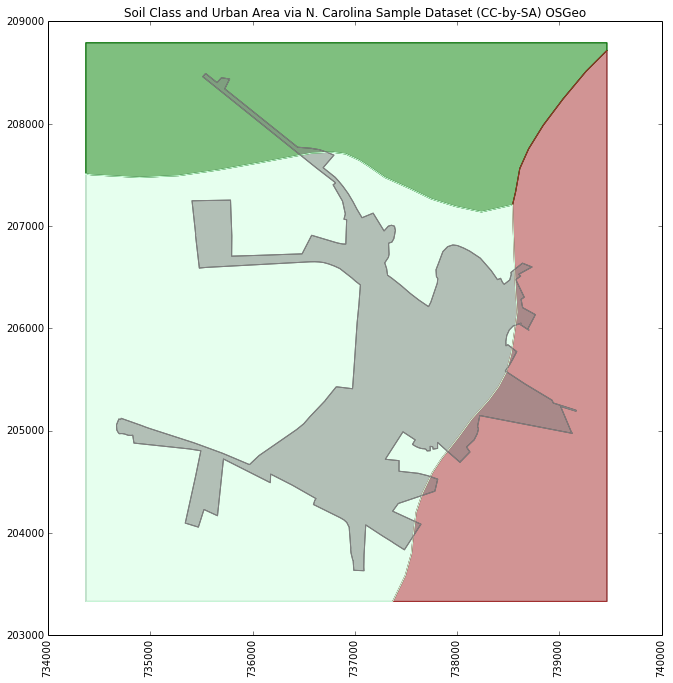

In [10]:

fig, ax = plt.subplots(figsize=(11,11))
plt.title("Soil Class and Urban Area via N. Carolina Sample Dataset (CC-by-SA) OSGeo")

cnt = 0
for key in dst_geoms :
    ## cnt mod (number of colors) is always a safe index into colors[]
    color = soil_colors[ cnt%len(soil_colors) ]
    plot_multipolygon(ax, dst_geoms[key], color=color)
    cnt += 1
    
cnt = 0
color = 'gray'
with fiona.open( out_farmville ) as f:
    for rec in f:
        plot_multipolygon(ax, src_geoms[cnt], color=color)
        cnt += 1

#ax.add_patch(Polygon( src_geoms[0].centroid, facecolor='black', alpha=0.5))

labels = ax.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 


In [11]:
## show all the variables defined so far
%whos

Variable              Type           Data/Info
----------------------------------------------
OrderedDict           type           <class 'collections.OrderedDict'>
Polygon               type           <class 'matplotlib.patches.Polygon'>
ax                    AxesSubplot    Axes(0.125,0.125;0.775x0.775)
bottom_bnds           float          203329.414199
cnt                   int            1
color                 str            gray
crs                   dict           n=11
defaultdict           type           <type 'collections.defaultdict'>
dst_geoms             OrderedDict    OrderedDict([(u'NC038', <<...>ect at 0x7f81716c18d0>)])
f                     Collection     <closed Collection '/tmp/<...>de 'r' at 0x7f816f057250>
fig                   Figure         Figure(880x880)
fiona                 module         <module 'fiona' from '/us<...>ages/fiona/__init__.pyc'>
gsl                   unicode        NC035
infile                str            /usr/local/share/data/nor<...>olina/sh

In [12]:
## what geomtries have been created ?
print 'src_geoms len: ',len(src_geoms)
print 'dst_geoms len: ',len(dst_geoms )

src_geoms len:  1
dst_geoms len:  3


In [13]:
## buffer the urbanarea by N meters
##  save the result in the source-geometry list

src_geom_buffered = src_geoms[0].buffer(166)
src_geoms[1] = src_geom_buffered


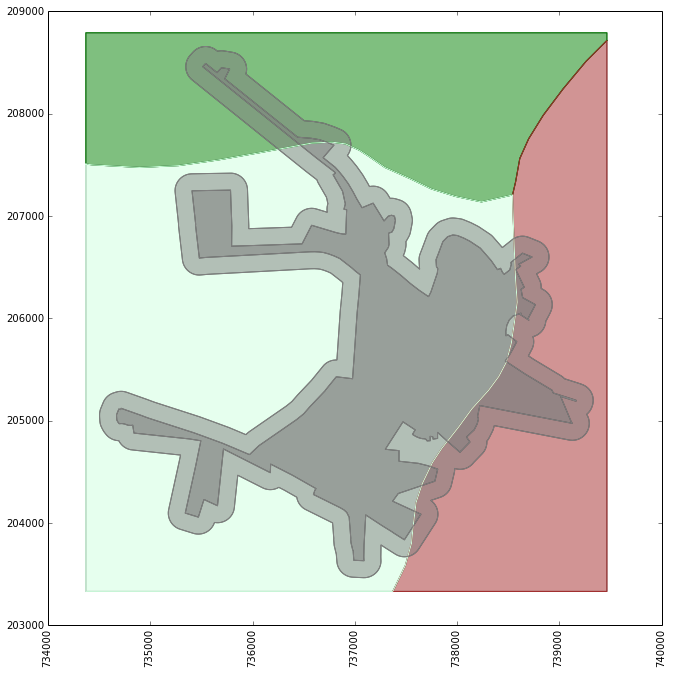

In [14]:
fig, ax = plt.subplots(figsize=(11,11))

cnt = 0
for key in dst_geoms :
    color = soil_colors[ cnt%len(soil_colors) ]
    plot_multipolygon(ax, dst_geoms[key], color=color)
    cnt += 1

plot_multipolygon(ax, src_geoms[1], color='gray')
plot_multipolygon(ax, src_geoms[0], color='gray')
    
labels = ax.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 


In [15]:
## take the intersection of each soil area against the buffered poly of interest
##  store into a third convenient list
res_geoms = OrderedDict()
for key in dst_geoms:
    res_geoms[key] = src_geom_buffered.intersection( dst_geoms[key] )

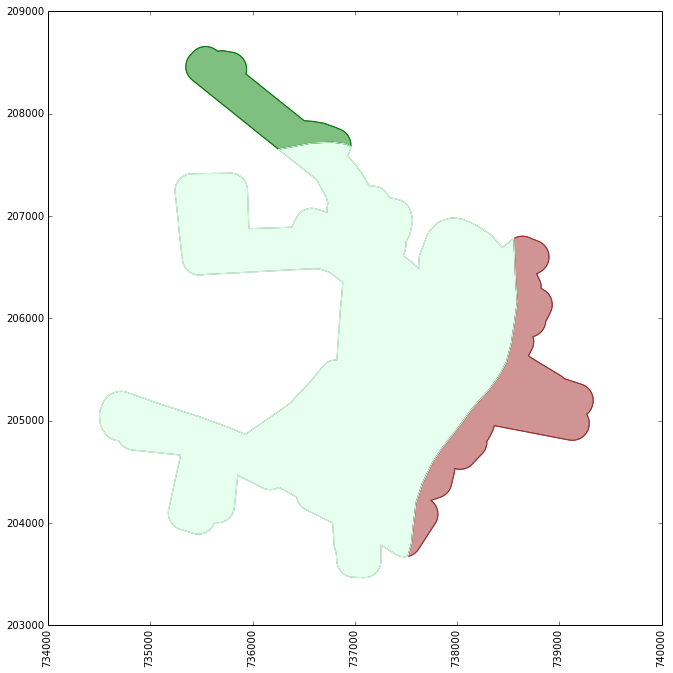

In [16]:
fig, ax = plt.subplots(figsize=(11,11))

cnt = 0
for key in res_geoms :
    color = soil_colors[ cnt%len(soil_colors) ]
    plot_multipolygon(ax, res_geoms[key], color=color)
    cnt += 1
    
labels = ax.get_xticklabels() 
for label in labels: 
    label.set_rotation(90) 


In [17]:
## define a lookup table of mock attributes of each soil type
##  (substitute a real data source here)

soils_lkup = {
  'NC038' : { 'TEXTURE_CLAY':0.53, 'TEXTURE_SILT':0.33, 'TEXTURE_SAND':0.44 },
  'NC035' : { 'TEXTURE_CLAY':0.70, 'TEXTURE_SILT':0.33, 'TEXTURE_SAND':0.44 },
  'NC034' : { 'TEXTURE_CLAY':0.23, 'TEXTURE_SILT':0.74, 'TEXTURE_SAND':0.44 }
}

## get a rough total area for display purposes
sum_areas = 0.0
for key in res_geoms:
    sum_areas += int(res_geoms[key].area)

## record the area and percentage area in a convenient dictionary 
tdd = {}
for key in res_geoms:
    tdd[key] = soils_lkup[key]
    tdd[key]['area'] = int(res_geoms[key].area)
    tdd[key]['perc'] = int((res_geoms[key].area/sum_areas)*100)/100.0


In [18]:
## Now all attributes for visualization are available in a single dict
##  in a larger system this could be delivered for serving graphical reports
tdd

{u'NC034': {'TEXTURE_CLAY': 0.23,
  'TEXTURE_SAND': 0.44,
  'TEXTURE_SILT': 0.74,
  'area': 1322002,
  'perc': 0.13},
 u'NC035': {'TEXTURE_CLAY': 0.7,
  'TEXTURE_SAND': 0.44,
  'TEXTURE_SILT': 0.33,
  'area': 7781207,
  'perc': 0.8},
 u'NC038': {'TEXTURE_CLAY': 0.53,
  'TEXTURE_SAND': 0.44,
  'TEXTURE_SILT': 0.33,
  'area': 590298,
  'perc': 0.06}}

In [19]:
## What matplotlib pylot graphs are available ?
## http://matplotlib.org/api/pyplot_api.html
##
##   Use IPython built-in help to discover pie chart attributes

plt.pie?


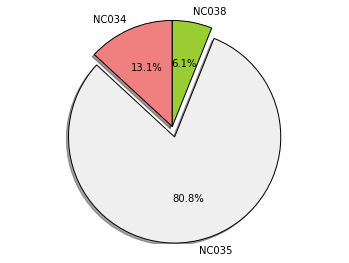

In [20]:
# The slices will be ordered and plotted counter-clockwise.
labels = [ 'NC034', 'NC035', 'NC038' ]
sizes = [  tdd['NC034']['perc']*100, tdd['NC035']['perc']*100, tdd['NC038']['perc']*100 ]
pie_colors = ['lightcoral', '#eeefee', 'yellowgreen']
# only "explode" the 2nd slice (i.e. 'NC035')
explode = (0, 0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=pie_colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.show()
